In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_log_error,mean_squared_error, r2_score


In [3]:
df = pd.read_csv("train-test.csv")
df.head()

,N,Z,A,EL,m
0,0,1,1,H,1.007825
1,1,1,2,H,2.014102
2,2,1,3,H,3.016049
3,1,2,3,He,3.016029
4,0,3,3,Li,3.030775


In [4]:
m_P= 1.0078764
m_N= 1.0086654
#calculating binding energy per nucleon using atomic mass evaluation
df['be']= (df['Z']* m_P + df['N']* m_N - df['m'])*931
df.head()

,N,Z,A,EL,m,be
0,0,1,1,H,1.007825,0.047824
1,1,1,2,H,2.014102,2.271660
2,2,1,3,H,3.016049,8.526025
3,1,2,3,He,3.016029,7.810048
4,0,3,3,Li,3.030775,-6.652740


In [5]:
df.drop("EL", axis = 1, inplace = True)

In [6]:
# Let's make it look a little prettier
corr_matrix = df.corr()
corr_matrix

,N,Z,A,m,be
N,1.000000,0.972859,0.995812,0.995827,0.990375
Z,0.972859,1.000000,0.989941,0.989916,0.988218
A,0.995812,0.989941,1.000000,1.000000,0.995995
m,0.995827,0.989916,1.000000,1.000000,0.995931
be,0.990375,0.988218,0.995995,0.995931,1.000000


In [7]:
# Random seed for reproducibility
np.random.seed(42)
# Everything except target variable
X = df.drop("be", axis=1)

# Target variable
y = df.be
# Split into train & test set

In [8]:
from sklearn.model_selection import train_test_split
# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, # independent variables 
                                                    y,test_size = 0.2, random_state=42) 
df1 = pd.concat([X_train,y_train], axis = 1)
df2 = pd.concat([X_test,y_test], axis = 1)

In [9]:
reg1 = RandomForestRegressor(n_estimators=1000,random_state=42)
reg1.fit(X_train,y_train)

y_pred = reg1.predict(X_test)
y_pred= pd.DataFrame(y_pred)

print("accuracy :",reg1.score(X_test,y_test),"mean_absolute_error :", mean_absolute_error(y_test,y_pred), 
      "root mean square error:",np.sqrt(mean_squared_error(y_test,y_pred)))

accuracy : 0.9999445628872428 mean_absolute_error : 2.535196723418478 root mean square error: 4.026917907395119


In [10]:
y_pred.to_csv("rfr.csv")

In [11]:
reg1 = MLPRegressor(hidden_layer_sizes=(64,32,16,8),
                       max_iter = 1000,random_state=42)
reg1.fit(X_train,y_train)

y_pred = reg1.predict(X_test)
y_pred= pd.DataFrame(y_pred)
y_pred.to_csv("mlp.csv")
print("accuracy :",reg1.score(X_test,y_test),"mean_absolute_error :", mean_absolute_error(y_test,y_pred), 
      "root mean square error:",np.sqrt(mean_squared_error(y_test,y_pred)))

accuracy : 0.9999481406472522 mean_absolute_error : 3.089163969937577 root mean square error: 3.894807704741745


In [12]:
reg1 = XGBRegressor(n_estimators=1000,max_depth=100,gamma = 5,learning_rate = 0.01,random_state = 42)
reg1.fit(X_train,y_train)

y_pred = reg1.predict(X_test)
y_pred= pd.DataFrame(y_pred)
y_pred.to_csv("xgb.csv")
print("accuracy :",reg1.score(X_test,y_test),"mean_absolute_error :", mean_absolute_error(y_test,y_pred), 
      "root mean square error:",np.sqrt(mean_squared_error(y_test,y_pred)))

accuracy : 0.9999378564354068 mean_absolute_error : 2.9579439859218377 root mean square error: 4.263542092081247


In [13]:
df2 = pd.concat([X_test,y_test], axis = 1)
# defining constants df2 from rholf
a_V= 15.75
a_S= 17.8
a_C= 0.711
a_A= 23.7
a_P= 11.18
#providing condition for last constant which is positive for even-even Z,N(even A) ,
#negative for odd-odd Z,N(even A) and zero for odd A
sgn = np.zeros(df2['Z'].shape) 
sgn[(df2['Z']%2) & (df2['N']%2)] = -1 
sgn[~(df2['Z']%2) & ~(df2['N']%2)] = +1
#calculating binding energy using semi-empirical mass formula
df2['BE_SEMF']= (a_V* df2['A'] - a_S* df2['A']**(2/3) - a_C * df2['Z']* (df2['Z']- 1) / df2['A']**(1/3) - 
             a_A * (df2['A']-2*df2['Z'])**2/df2['A'] + sgn * a_P/df2['A']**(1/2))
df2["be_a_semf"] = df2['BE_SEMF']/df2["A"]

In [14]:
rmse_semf = np.sqrt(mean_squared_error(df2.be,df2.BE_SEMF))
mae_semf = mean_absolute_error(df2.be,df2.BE_SEMF)

R2_semf = r2_score(df2.be,df2.BE_SEMF)
print("MAE_SEMF =",mae_semf,",RMSE_SEMF =",rmse_semf,R2_semf)

MAE_SEMF = 5.19406675070005 ,RMSE_SEMF = 6.702310913828531 0.9998464307751658


In [15]:
dfx = pd.read_csv("predict.csv")
dfx.head()

,N,Z,A,m,be,be_RFR,be_XGB,be_MLP,BE_SEMF,be_a_semf,be_a_RFR,be_a_XGB,be_a_MLP,be_a
0,0,1,1,1.007825,0.047824,-1.839576,-2.028259,0.648924,-25.750000,-25.750000,-1.839576,-2.028259,0.648924,0.047824
1,3,3,6,6.015123,32.121926,28.064957,30.711208,33.937543,33.378025,5.563004,4.677493,5.118535,5.656257,5.353654
2,6,1,7,7.052749,6.628534,22.036381,17.659521,9.205379,-39.528499,-5.646928,3.148054,2.522789,1.315054,0.946933
3,3,5,8,8.024607,37.957770,39.437965,46.731680,41.712099,35.840000,4.480000,4.929746,5.841460,5.214012,4.744721
4,6,2,8,8.033922,31.489495,34.351936,40.641950,26.633133,6.689000,0.836125,4.293992,5.080244,3.329142,3.936187


In [16]:
dfx["be_a_RFR"]= dfx["be_RFR"]/ dfx["A"]
dfx["be_a_XGB"]= dfx["be_XGB"]/ dfx["A"]
dfx["be_a_MLP"]= dfx["be_MLP"]/ dfx["A"]
dfx.to_csv("predict.csv")

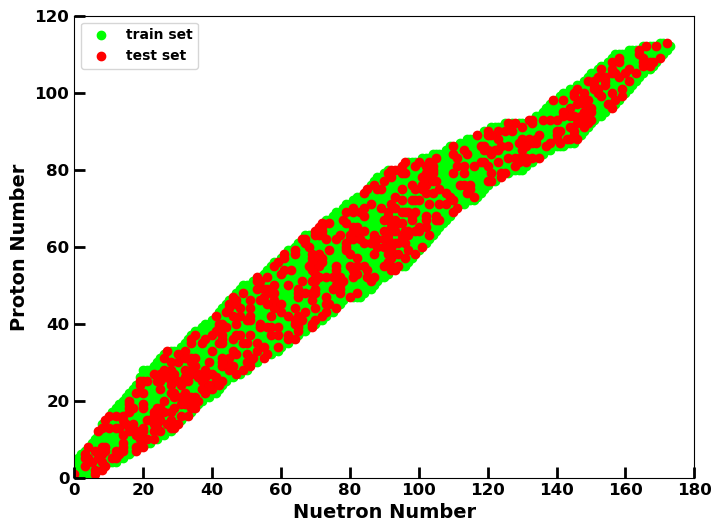

In [17]:
fig, ax = plt.subplots(figsize=(8,6)) 

ax.scatter(df1["N"],df1["Z"],  label ="train set",color ="lime")
ax.scatter(df2["N"], df2["Z"],  label ="test set", color= "red")
ax.set_xlabel(r'Nuetron Number',fontsize=14,fontweight="bold") 
ax.set_ylabel(r'Proton Number',fontsize=14,fontweight="bold")
plt.xticks(color = 'k', fontsize=12,fontweight="bold")
plt.yticks(color = 'k', fontsize=12,fontweight="bold")
plt.tick_params(direction='in')
plt.tick_params(axis='x',length=8,width=2)
plt.tick_params(axis='y',length=8,width=2)
ax.legend(prop=dict(weight='bold'));
ax.set_ylim(0,120)
ax.set_xlim(0,180)
plt.savefig('train_test.png', dpi =600,bbox_inches='tight')
plt.show()

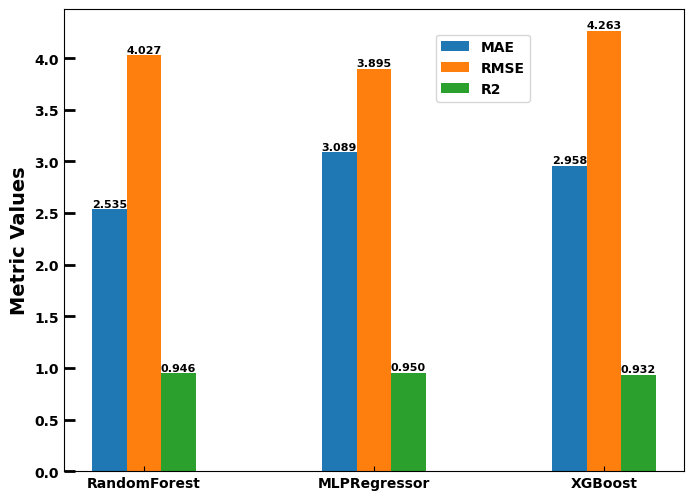

In [18]:
# Data
models = ["RandomForest","MLPRegressor","XGBoost"]
mae_values = [2.535,3.089,2.958]
rmse_values = [4.027,3.895,4.263]
r2_values = [0.946,0.950,0.932]

# Bar width
bar_width = 0.15

# Set up the bar positions
bar_positions_mae = np.arange(len(models))
bar_positions_rmse = bar_positions_mae + bar_width
bar_positions_r2 = bar_positions_rmse + bar_width

# Create the bar plot
plt.figure(figsize =(8,6))
plt.bar(bar_positions_mae, mae_values, width=bar_width, label='MAE')
plt.bar(bar_positions_rmse, rmse_values, width=bar_width, label='RMSE')
plt.bar(bar_positions_r2, r2_values, width=bar_width, label='R2')
# Add values on top of the bars with formatting to two decimal places
for i, value in enumerate(mae_values):
    plt.text(bar_positions_mae[i], value + 0.005, f'{value:.3f}', ha='center', va='bottom',fontsize=8,fontweight = "bold")

for i, value in enumerate(rmse_values):
    plt.text(bar_positions_rmse[i], value + 0.005, f'{value:.3f}', ha='center', va='bottom',fontsize=8,fontweight = "bold")

for i, value in enumerate(r2_values):
    plt.text(bar_positions_r2[i], value + 0.005, f'{value:.3f}', ha='center', va='bottom',fontsize=8,fontweight = "bold")
# Set labels and title
plt.ylabel('Metric Values',fontsize=14,fontweight = "bold")
plt.xticks(bar_positions_rmse, models)
plt.xticks(color = 'k', fontsize=10,fontweight = "bold")
plt.yticks(color = 'k', fontsize=10,fontweight = "bold")
plt.tick_params(axis='y',length=8,width=2)
plt.tick_params(direction='in')
plt.legend(prop=dict(weight='bold'),loc = (0.6,0.8))
plt.savefig('compare.png', dpi =600, bbox_inches='tight')
# Show the plot
plt.show()